# GloVe-BiLSTM Evaluation on the Test Set

## Imports, Fixed SEED, GPU

These settings are chosen in a way to ensure best reproducibilty of the results.

Use GPU as computing device if available to improve computation time drastically.

In [90]:
import torch
import numpy as np
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.enabled = False 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Only necessary for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


## Data Set definition

Here we define the Dataset Structure and load the training and test dataset as TabularDataset.

The columns PhraseId and SentenceId are artifacts of the raw Dataset-structure and can be omitted for training and testing.

`test_mapped.tsv` was created by mapping the phrases to the right sentiments. 

In [91]:
# Create Field objects
PHRASE = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)
SENTIMENT = data.LabelField()

# Create tuples representing the columns
fields = [
  (None, None), # ignore PhraseId column
  (None, None), # ignore SentenceId column
  ('Phrase', PHRASE),
  ('Sentiment', SENTIMENT)
]

# Load the dataset in tsv format
train_ds, test_ds = data.TabularDataset.splits(
   path = './data',
   train = 'train.tsv',
   test = 'test_mapped.tsv',
   format = 'tsv',
   fields = fields,
   skip_header = True
)

## Creation of vocabulary

Create key for every unique Phrase- or Sentiment-Token and assign to unique value.

Then create word embedding for every token in the Phrase vocabulary.

Note: The vocabulary DataField "SENTIMENT" is not created from the training data to preserve the correct indexing: 

"{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}", and instead a vector of key value pairs is provided.

In [92]:
# Build vocabulary (using Glove pre-trained word embeddings, dimensionality = 100)
PHRASE.build_vocab(train_ds,
                    vectors = "glove.6B.100d", 
                    unk_init = torch.Tensor.normal_)

labels = np.array(['0', '1', '2', '3', '4'])

SENTIMENT.build_vocab(labels) # Custom indexing is necessary for correct mapping; {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

print(f"Unique tokens in PHRASE vocabulary: {len(PHRASE.vocab)}")
print(f"Unique tokens in SENTIMENT vocabulary: {len(SENTIMENT.vocab)}")
print(f"Number of tokens, vector dimension: {PHRASE.vocab.vectors.shape}")

Unique tokens in PHRASE vocabulary: 17149
Unique tokens in SENTIMENT vocabulary: 5
Number of tokens, vector dimension: torch.Size([17149, 100])


## Creation of the Iterators

The Iterators are used to yield one batch of the data at a time.

In [93]:
BATCH_SIZE = 32

# Creating the iterators
train_iterator, test_iterator = data.BucketIterator.splits(
    (train_ds, test_ds), 
    batch_size = BATCH_SIZE,
    sort = False,
    sort_key = lambda x: len(x.Phrase),
    sort_within_batch = True,
    device = device)

## Model Definition

In [94]:
import torch.nn as nn

class GloVe_BiLSTM(nn.Module):
    """
    This class defines the model, its layers and t 

    param self: model instance
    param input_dim: int value of vocabulary size
    param embedding_dim: int value of embedding dimension
    param hidden_dim: int value of hidden layer dimension
    param output_dim: int value of number of classes
    param n_layers: int value of number of hidden layers
    param bidirectional: boolean value whether LSTM is bidirectional or not
    param dropout: float value of the dropout rate
    param pad_idx: int value of <pad> token index
    """
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        """
        forward pass through the model, gets called when calling a model instance

        :param self: model instance
        :param text: tokenized sentence [shape: sent length , batch size]
        :param text_lengths: int value of the longest sentence length in batch [shape: batch size]
        
        :return predicted labels [shape: batch size , num classes]
        """
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

## Hyper-Parameter Definition


In [95]:
INPUT_DIM = len(PHRASE.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = len(SENTIMENT.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
PAD_IDX = PHRASE.vocab.stoi[PHRASE.pad_token]

model = GloVe_BiLSTM( INPUT_DIM, 
                      EMBEDDING_DIM, 
                      HIDDEN_DIM, 
                      OUTPUT_DIM, 
                      N_LAYERS, 
                      BIDIRECTIONAL, 
                      DROPOUT, 
                      PAD_IDX)

In [96]:
def count_parameters(model):
    """
        compute number of model parameters

        :param model: model instance
        
        :return int value of parameter number
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,027,609 trainable parameters


In [97]:
pretrained_embeddings = PHRASE.vocab.vectors

# replace the initial weights of the embedding layer with the pre-trained embeddings
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 2.1798, -1.5601, -0.4398,  ..., -0.0960, -0.7768, -1.0890],
        [-0.3552,  0.4732,  0.8660,  ...,  0.2483, -0.0049,  0.8731],
        [-0.1431,  0.0487,  0.0565,  ..., -0.0402, -0.3744,  0.5650]])

In [98]:
UNK_IDX = PHRASE.vocab.stoi[PHRASE.unk_token]

#  initialize <unk> and <pad> tokens to all zeros
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Optimizer


- Adaptive Momentum (Adam) Optimizer with included Momentum Term and Gradient Normalization.

- Regularization Term (weight decay) with small parameter lambda is additionally applied.

In [99]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), weight_decay = 0.00001)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-05
)


## Loss Function and Accuracy Method

For a multi-class classification task we use the CrossEntropy Loss and categorical accuracy as our performance metrics.

In [100]:
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [101]:
def categorical_accuracy(preds, y):
    """
        Returns relative accuracy per batch

        :param preds: predicted labels [shape: batch size x num classes]
        :param y: true labels [shape: batch size]
        
        :return predicted label [shape: batch size x num classes]
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

## Training Method and Evaluation Method

The train method gets called in every epoch and iterates through the dataset in batches. 
(forward pass, loss calculation, backpropagation, weight update)

The evaluate method calculates the performance of the model on the test set using the accuracy metric.

In [102]:
def train(model, iterator, optimizer, criterion):
    
    """
        Iterates through the dataset in batches with the following steps:
        forward pass -> loss calculation -> backpropagation -> weight update

        :param model: model instance
        :param iterator: train iterator
        :param optimizer: predefined optimizer
        :param criterion: predefined loss function

        :return value of train loss and train accuracy
    """

    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.Phrase
        
        predictions = model(text, text_lengths)
        
        loss = criterion(predictions, batch.Sentiment)
        
        acc = categorical_accuracy(predictions, batch.Sentiment)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [103]:

def evaluate(model, iterator, criterion):

    """
        calculates the loss and the accuracy of the model on the test set

        :param model: model instance
        :param iterator: test iterator
        :param criterion: predefined loss function

        :return value of test loss and test accuracy
    """
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
      
        for batch in iterator:

            text, text_lengths = batch.Phrase
            
            predictions = model(text, text_lengths)
            
            loss = criterion(predictions, batch.Sentiment)
            
            acc = categorical_accuracy(predictions, batch.Sentiment)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

            y_true.append(batch.Sentiment)
            y_pred.append(predictions)      
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Training and Evaluation

Auxiliary function to calculate the duration of the training time for one 
epoch.

In [104]:
import time

def epoch_time(start_time, end_time):
    """
        calculates epoch minutes and epoch seconds

        :param start_time: float value of start time
        :param end_time: float value of end time

        :return epoch minutes and epoch seconds
    """
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Training

Here the final training loop is executed N times. N is therefore the amount of training epochs. Early Stopping during Finetuning resulted in our choice of 4 epochs.

In [105]:
# Train the model with all of the training data
N_EPOCHS = 4

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    torch.save(model.state_dict(), 'model_LSTM.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 2s
	Train Loss: 0.925 | Train Acc: 61.97%
Epoch: 02 | Epoch Time: 1m 2s
	Train Loss: 0.777 | Train Acc: 67.97%
Epoch: 03 | Epoch Time: 1m 1s
	Train Loss: 0.720 | Train Acc: 70.21%
Epoch: 04 | Epoch Time: 1m 0s
	Train Loss: 0.682 | Train Acc: 71.77%


### Evaluation

In [113]:
# Test the trained model on the test data
model.load_state_dict(torch.load('model_LSTM.pt'))

#True and Predicted Label lists for visualization
y_true = []
y_pred = []

test_loss, test_acc = evaluate(model, test_iterator, criterion)


print("***** Final Evaluation Score *****")
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

***** Final Evaluation Score *****
Test Loss: 0.844 | Test Acc: 66.31%


## Visualization





In [107]:
#Auxilary Function - List to Tensor

y_true_concat = torch.empty(0, device=device)
for tens in range(len(y_true)):
  y_true_concat = torch.concat((y_true_concat, y_true[tens]),0)

y_pred_concat = torch.empty(0, device=device)
for tens in range(len(y_pred)):
  y_pred_concat = torch.concat((y_pred_concat, y_pred[tens]),0)

y_pred_argmax = y_pred_concat.argmax(1)

In [108]:
#Tensors to numpy() array and on CPU for Visualization
if y_true_concat.dtype == torch.float32:
  y_true_concat = y_true_concat.cpu().numpy()
  y_pred_argmax = y_pred_argmax.cpu().numpy()

### Classification Report

In [109]:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

label_names = ['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive']

#Classification Report
print('Classification Report:')
print(classification_report(y_true_concat, y_pred_argmax, digits=4, target_names = label_names))


Classification Report:
                   precision    recall  f1-score   support

         Negative     0.5469    0.2243    0.3181      2680
Somewhat Negative     0.5406    0.5495    0.5450     11521
          Neutral     0.7363    0.8343    0.7822     33842
Somewhat Positive     0.5609    0.5305    0.5453     12908
         Positive     0.6675    0.2996    0.4136      4376

         accuracy                         0.6632     65327
        macro avg     0.6105    0.4876    0.5208     65327
     weighted avg     0.6548    0.6632    0.6499     65327



### Confusion Matrix

Visualizing true and predicted labels.

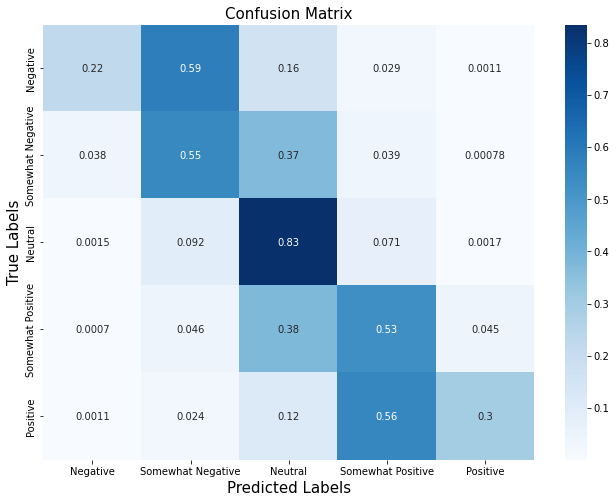

In [124]:
#Confusion Matrix
cm = confusion_matrix(y_true_concat, y_pred_argmax, normalize="true" ) 
#ax = plt.subplot()
fig, ax = plt.subplots(figsize=(11,8))
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues')
ax.set_title('Confusion Matrix', fontsize = 15)
ax.set_xlabel('Predicted Labels', fontsize = 15)
ax.set_ylabel('True Labels', fontsize = 15)
ax.xaxis.set_ticklabels(label_names)
ax.yaxis.set_ticklabels(label_names)
plt.show()

### Label Distribution bar chart

Visualize label distribution in test dataset.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


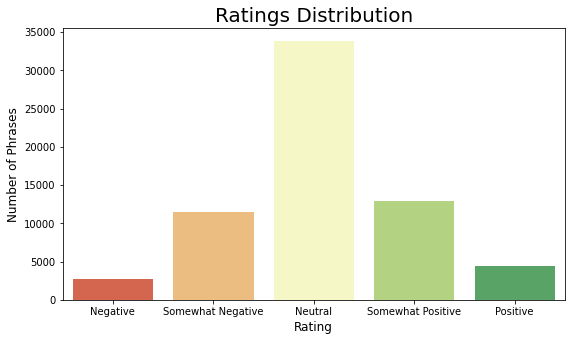

In [116]:

#Label Distribution
unique, counts = np.unique(y_true_concat, return_counts=True)
fig = plt.figure(figsize=(9, 5))
ax = sns.barplot(unique,counts, palette='RdYlGn')
plt.title("Ratings Distribution",fontsize = 20)
plt.ylabel('Number of Phrases', fontsize = 12)
plt.xlabel('Rating', fontsize = 12)
ax.xaxis.set_ticklabels(label_names)
plt.show()